*ipykernel* was used with the libraries described below  
For correct operation, you also need:
* `ipywidgets`
* `jupyter nbextension enable --py widgetsnbextension`

In [1]:
import re
import os

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from catboost.text_processing import Tokenizer

# Functions

In [2]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["figure.dpi"] = 400
plt.rcParams["font.size"] = 16
plt.rcParams["axes.grid"] = True

## Function to extract the ratio of the number of offers of a manager with high interest, to the total number of offers of this manager

In [3]:
def manager_feature(df_train, df_test):
    new_df_train = df_train.copy()
    new_df_test = df_test.copy()
    work_with_date(new_df_train)
    work_with_date(new_df_test)
    all_data = pd.concat([new_df_train, new_df_test])
    
    all_count = all_data.groupby(["manager_id", "month", "year"])["manager_id"].count().\
        to_frame().rename(columns={"manager_id":"manager_count"}).groupby("manager_id").shift()
    high_count = all_data[all_data["interest_level"] == "high"].groupby(["manager_id", "month", "year"])["manager_id"].count().\
        to_frame().rename(columns={"manager_id":"manager_high"}).groupby("manager_id").shift()
    
    new_df_test = new_df_test.merge(all_count, on=["manager_id", "month", "year"], how="left")
    new_df_test = new_df_test.merge(high_count, on=["manager_id", "month", "year"], how="left")
    new_df_test["manager_success"] = new_df_test["manager_high"] / new_df_test["manager_count"]
    
    new_df_train = new_df_train.merge(all_count, on=["manager_id", "month", "year"], how="left")
    new_df_train = new_df_train.merge(high_count, on=["manager_id", "month", "year"], how="left")
    new_df_train["manager_success"] = new_df_train["manager_high"] / new_df_train["manager_count"]
    
    return new_df_train, new_df_test

## Split date into day, month, year

In [4]:
def work_with_date(df):
    df["day"] = df["created"].apply(lambda x: x.day)
    df["month"] = df["created"].apply(lambda x: x.month)
    df["year"] = df["created"].apply(lambda x: x.year)

## Label encoding for id and target

In [5]:
def label_encoding_data(df):
    lbl = LabelEncoder()
    df["manager_id"] = lbl.fit_transform(df["manager_id"])
    df["building_id"] = lbl.fit_transform(df["building_id"])

In [6]:
def label_encoding_target(df):
    lbl = LabelEncoder()
    df["interest_level"] = lbl.fit_transform(df["interest_level"])
    print(lbl.classes_)

## General function of extracting new features and data preparation

In [7]:
def prepare_data(df, data_type="train"):
    df_copy = df.copy()
    
    df_copy["photos_number"] = df_copy["photos"].apply(lambda x: len(x))
    df_copy["room_price"] = df_copy["price"] / df_copy["bedrooms"]
    df_copy["description_num_words"] = df_copy["description"].apply(
        lambda x: 
        len(Tokenizer(lowercasing=True, separator_type='BySense',token_types=['Word', 'Number']).tokenize(x)))
    df_copy["features_num"] = df_copy["features"].apply(len)
    df_copy["description"] = df_copy["description"].apply(lambda x: re.sub(r"<.*?>", '', x))
    df_copy["features"] = df_copy["features"].apply(lambda x: " ".join(x))
    
    work_with_date(df_copy)
    label_encoding_data(df_copy)
    
    df_copy.drop(["photos", "display_address", "street_address", "created", "manager_count", "manager_high"],
                 axis = 1,
                 inplace = True)
    
    if data_type == "train":
        label_encoding_target(df_copy)
        
        return df_copy.loc[:, df_copy.columns != "interest_level"], df_copy["interest_level"]
    
    return df_copy

## Create result.csv

In [8]:
def create_result(model, result_data):
    pd.concat([result_data["listing_id"].to_frame(), 
               pd.DataFrame(model.predict_proba(prepare_data(result_data, "test")),
               columns = ['high','low','medium'])], 
               axis=1).to_csv("result.csv", index=False)

## Plot distribution of target

In [9]:
def plot_target_distribution(all_y, train_y, test_y):
    fig, ax = plt.subplots(1, 3)
    fig.suptitle("Target distribution")
    
    all_y.value_counts(normalize=True).plot(kind="bar", ax=ax[0], title="All")
    train_y.value_counts(normalize=True).plot(kind="bar", ax=ax[1], title="Train")  
    test_y.value_counts(normalize=True).plot(kind="bar", ax=ax[2], title="Test")
    
    fig.tight_layout()

## Plot of grid search results

In [10]:
def plot_grid_search_results(gsr):
    fig, ax = plt.subplots(2, 1)
    fig.suptitle("Grid search results")

    hbars = ax[0].barh(list(grid_search_result["params"].keys()),
            [grid_search_result["params"]["depth"],
             grid_search_result["params"]["l2_leaf_reg"], 
             grid_search_result["params"]["learning_rate"]])
    ax[0].bar_label(hbars, padding=10)
    ax[0].set_title("Best params")

    ax[1].plot(grid_search_result["cv_results"]["iterations"], grid_search_result["cv_results"]["test-MultiClass-mean"])
    ax[1].set_title("Learning curve")
    ax[1].set_xlabel("iterations")
    ax[1].set_ylabel("metric")

    fig.tight_layout()

# Read data

In [11]:
df_test = pd.read_json("data/test.json.zip", compression="zip")
df_test["created"] = pd.to_datetime(df_test["created"])
df_test.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
2,1.0,0,0,2016-06-17 01:23:39,Spacious studio in Prime Location. Cleanbuildi...,Sullivan Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7260,7174566,-74.0026,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7174566_ba3a35c5...,2295,115 Sullivan Street
3,1.0,2,f9c826104b91d868e69bd25746448c0c,2016-06-21 05:06:02,For immediate access call Bryan.<br /><br />Bo...,Jones Street,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7321,7191391,-74.0028,41735645e0f8f13993c42894023f8e58,[https://photos.renthop.com/2/7191391_8c2f2d49...,2900,23 Jones Street
5,1.0,1,81062936e12ee5fa6cd2b965698e17d5,2016-06-16 07:24:27,Beautiful TRUE 1 bedroom in a luxury building ...,Exchange Place,"[Roof Deck, Doorman, Elevator, Fitness Center,...",40.7054,7171695,-74.0095,a742cf7dd3b2627d83417bc3a1b3ec96,[https://photos.renthop.com/2/7171695_089ffee2...,3254,20 Exchange Place


In [12]:
df_train = pd.read_json("data/train.json.zip", compression="zip")
df_train["created"] = pd.to_datetime(df_train["created"])
df_train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


In [13]:
df_sample_submission = pd.read_csv("data/sample_submission.csv.zip", compression="zip")
df_sample_submission.head()

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683
3,7191391,0.077788,0.227529,0.694683
4,7171695,0.077788,0.227529,0.694683


# EDA

In [14]:
df_train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level'],
      dtype='object')

In [15]:
df_train.dtypes

bathrooms                 float64
bedrooms                    int64
building_id                object
created            datetime64[ns]
description                object
display_address            object
features                   object
latitude                  float64
listing_id                  int64
longitude                 float64
manager_id                 object
photos                     object
price                       int64
street_address             object
interest_level             object
dtype: object

In [16]:
df_train.isna().value_counts().to_frame()

,,,,,,,,,,,,,,,0
bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,
False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,49352


# Train model

New features: 
* `photos_number` - number of photos
* `room_price` - room price
* `discription_num_words` - number of words in discription
* `features_num` - number of features
* `manager_success` - the ratio of the number of high demand manager's offers to that manager's total number of offers. Moreover, for example, for the 6th month of 2016, information for the 5th month of 2016 will be used in order to avoid "looking" into the future

## Calling data preparation functions and splitting into train/test

In [17]:
df_train, df_test = manager_feature(df_train, df_test)

In [18]:
all_X, all_y = prepare_data(df_train)

['high' 'low' 'medium']


In [19]:
train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, shuffle=True, train_size=0.75, stratify=all_y)

In [20]:
all_X.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'description', 'features',
       'latitude', 'listing_id', 'longitude', 'manager_id', 'price', 'day',
       'month', 'year', 'manager_success', 'photos_number', 'room_price',
       'description_num_words', 'features_num'],
      dtype='object')

## Target distribution

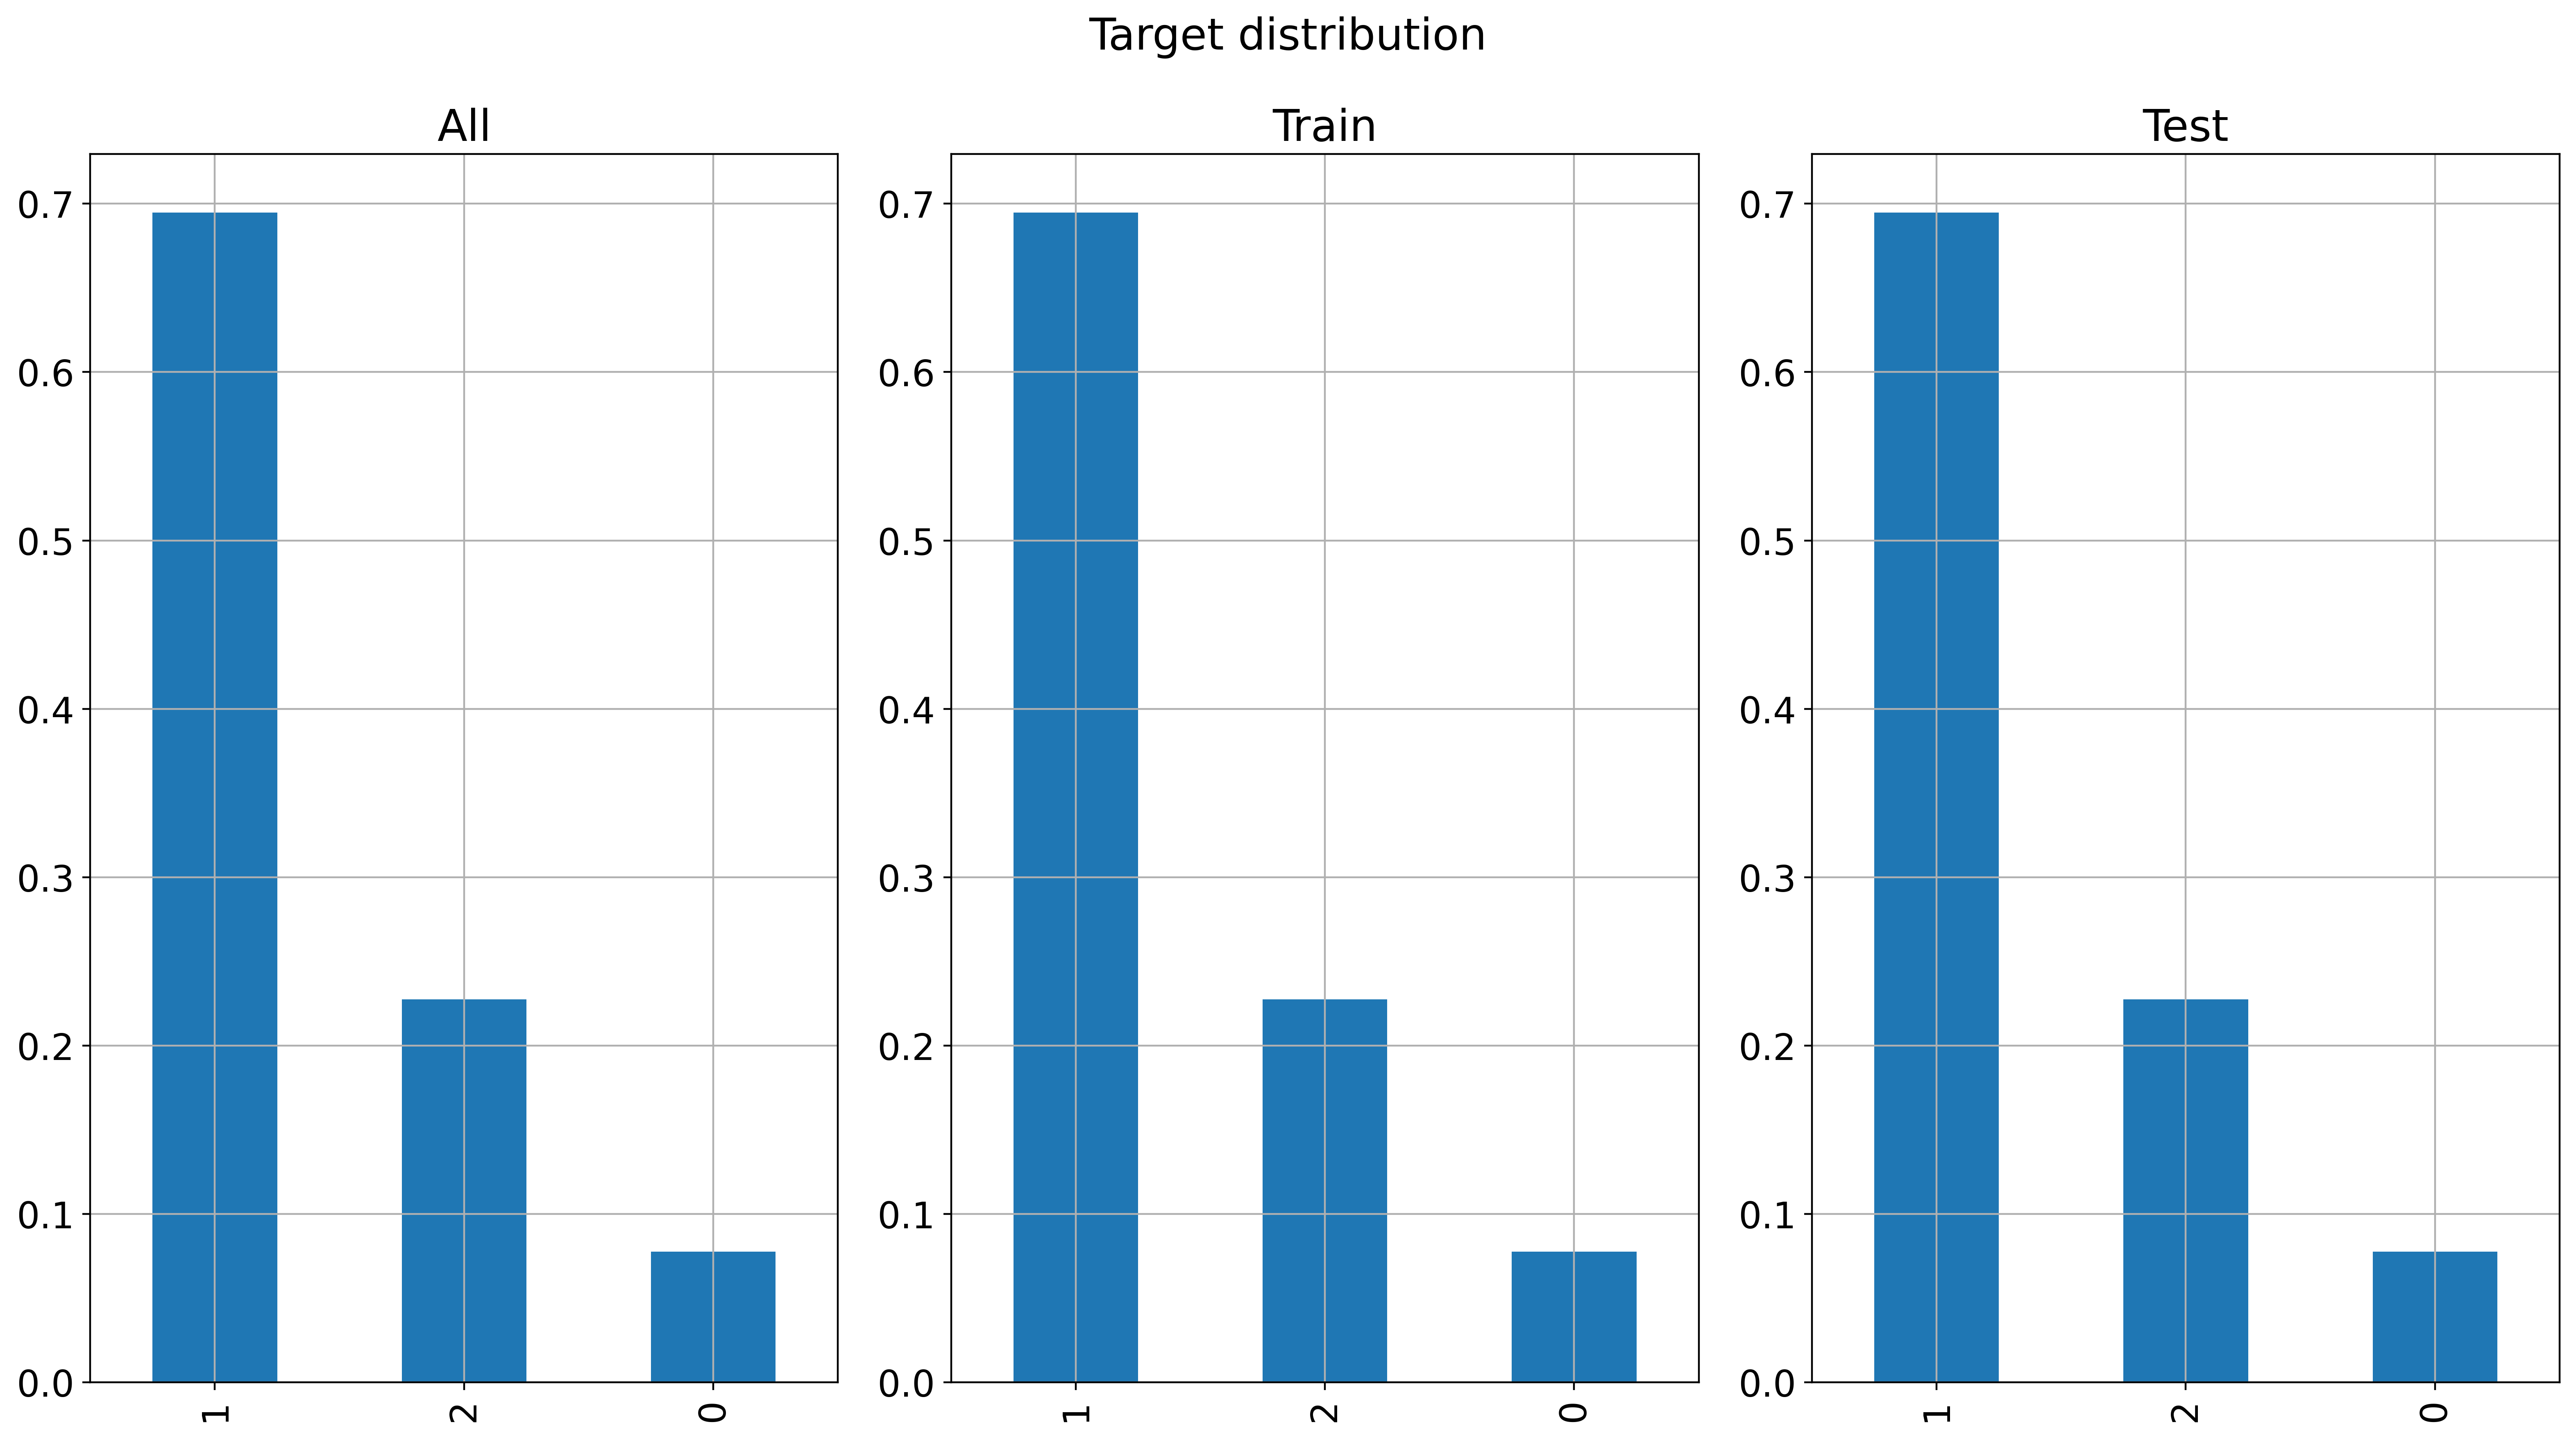

In [21]:
plot_target_distribution(all_y, train_y, test_y)

## Model training and param selection

Extracting extra features from text data with catboost

In [24]:
text_features=["description", "features"]
train_pool = Pool(train_X, train_y, text_features=text_features)
test_pool = Pool(test_X, test_y, text_features=text_features)

In [27]:
params = {
    "iterations":750,
    "loss_function":"MultiClass",
    "logging_level":"Silent"
}
model = CatBoostClassifier(**params)

In [28]:
grid = {'learning_rate': [0.01, 0.1, 0.25, 0.5, 1],
        'depth': [2, 3, 4],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid,
                                       X=train_pool,
                                       plot=True, 
                                       verbose=False,
                                       cv = 5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

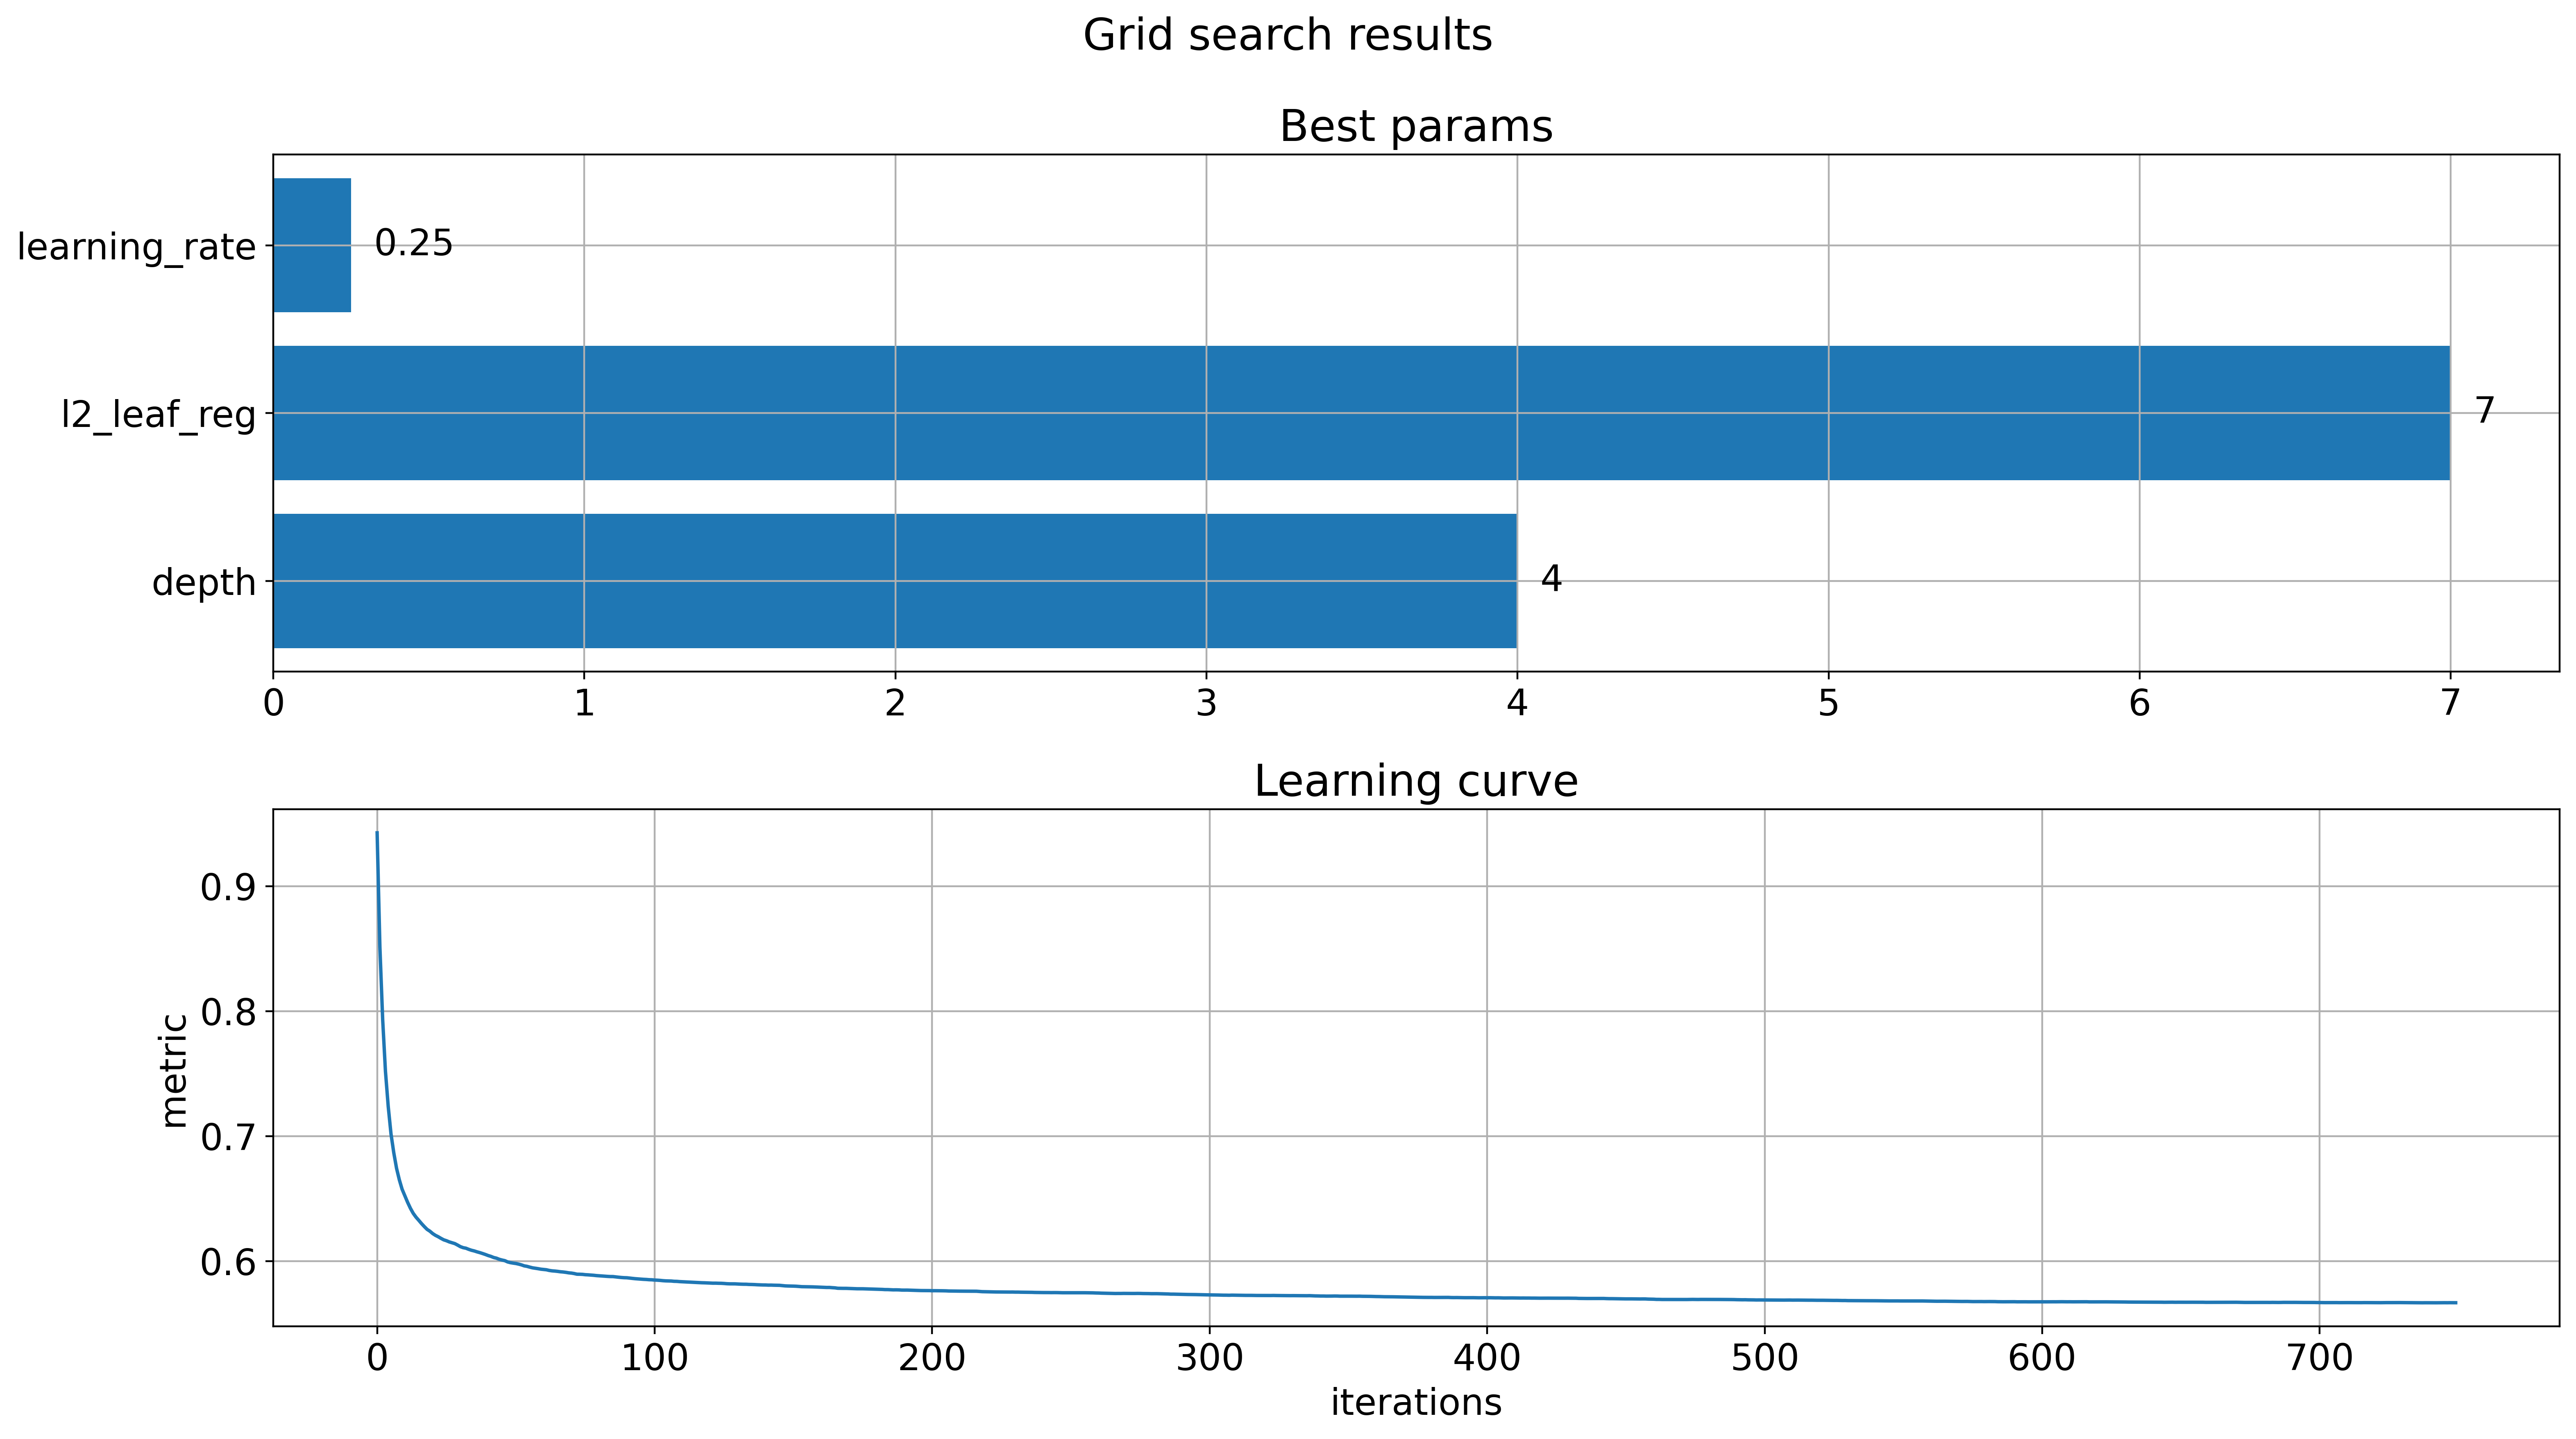

In [29]:
plot_grid_search_results(grid_search_result)

## Training on all data with best model params

In [30]:
model.fit(X=train_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Feature importance

<AxesSubplot:title={'center':'Feature importance'}>

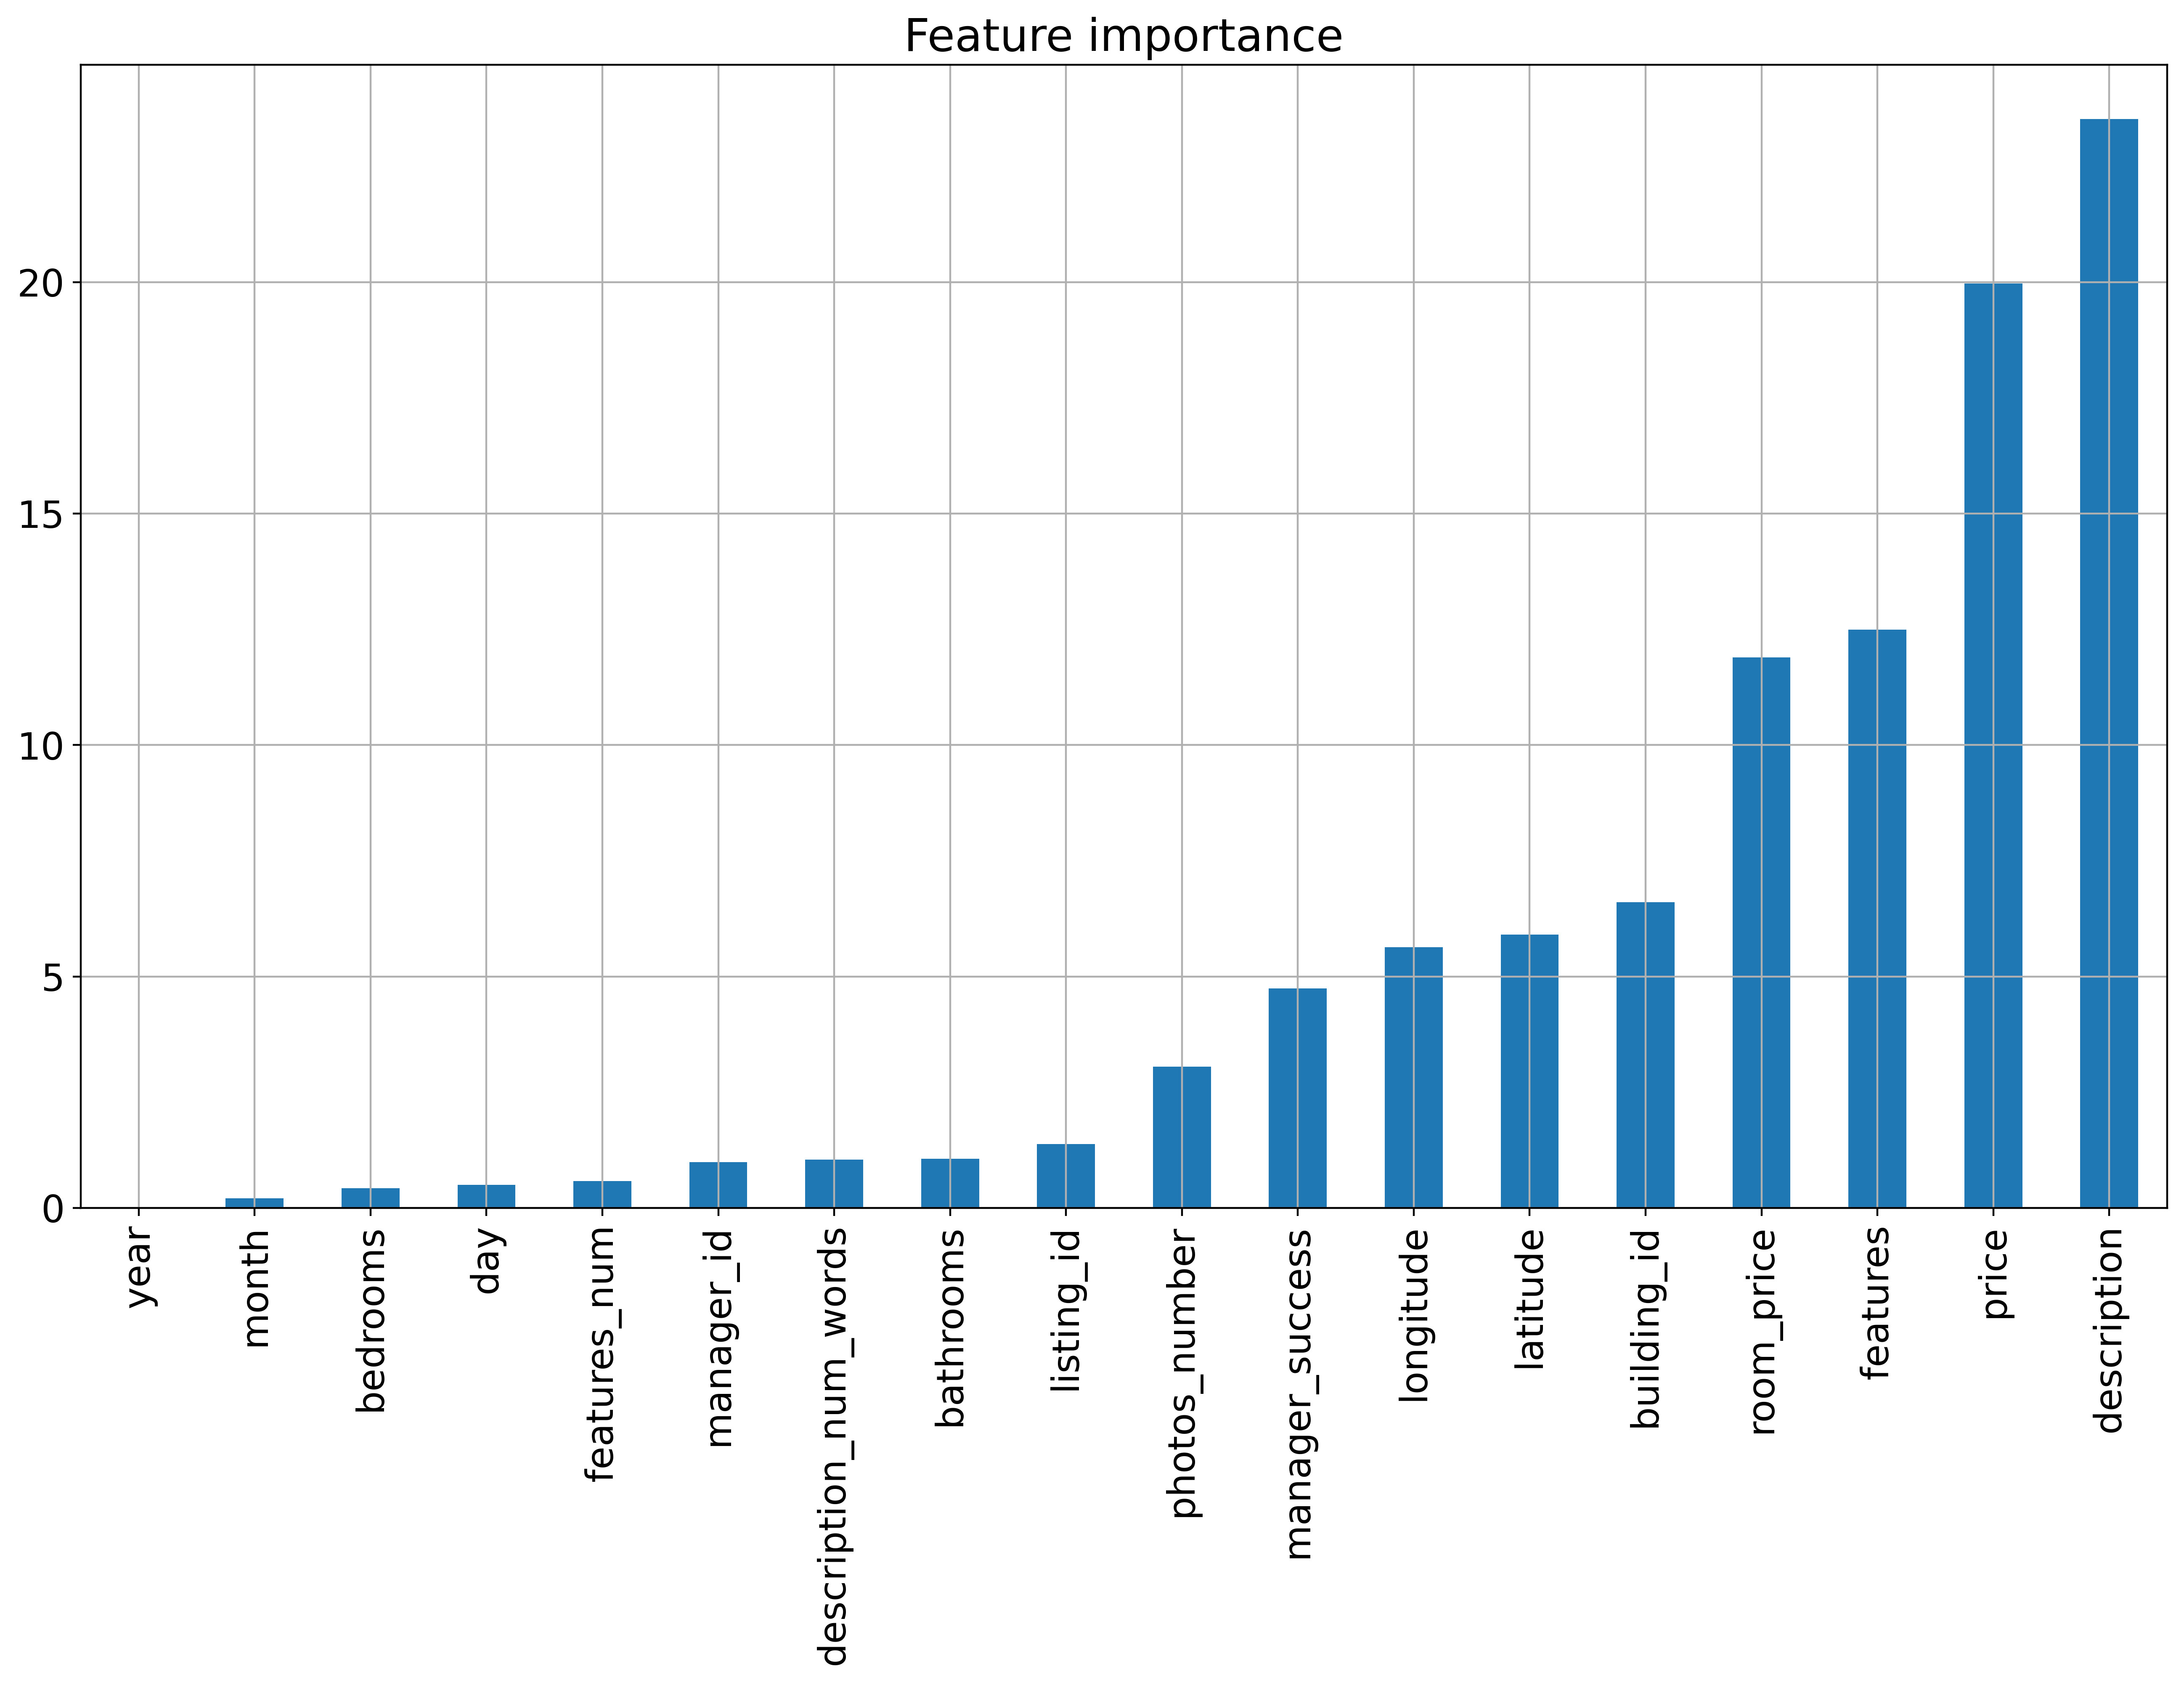

In [31]:
pd.Series(index = all_X.columns, data = model.get_feature_importance(train_pool)).sort_values().plot(kind = 'bar', title="Feature importance")

## Metrics

In [32]:
model.score(test_pool)

0.747365861565894

In [33]:
log_loss(test_y, model.predict_proba(test_X))

0.5573600028050911

# Get results

In [34]:
create_result(model, df_test)